In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from os.path import exists
import json
import pickle

import torch
import torch.optim as optim
from torch.nn import CrossEntropyLoss, Conv2d, Sequential, BatchNorm2d
from torch.utils.data import DataLoader

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torchinfo import summary

from ActiveShiftLayer import ASL
from util import test_loss, train_NN, loadMNIST, inference_time, plot_loss, plot_acc, plot_shifts

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

cuda


## MNIST LeNet

In [3]:
batch_size = 100
input_shape = (batch_size, 1, 28, 28)
num_labels = 10

train_dataset, train_dataloader, test_dataset, test_dataloader, classes = loadMNIST(batch_size)

In [4]:
# mock train_function of Optimizer to load the optimizer
train_function = None

with open('models/LeNet/LeNet_optimizer.pkl', 'rb') as file:
    LeNet_optim = pickle.load(file)

best_parameters = LeNet_optim.get_best_parameters(3)
print(best_parameters)
parameters = best_parameters[0]

[{'acc': 99.70666666666666, 'lr': 0.21875, 'momentum': 0.78125, 'p_randomTransform': 0.0625}, {'acc': 99.645, 'lr': 0.09375, 'momentum': 0.65625, 'p_randomTransform': 0.3125}, {'acc': 99.625, 'lr': 0.491943359375, 'momentum': 0.589599609375, 'p_randomTransform': 0.04345703125}]


In [5]:
from Models import LeNet

LeNN = LeNet(input_shape, num_labels=num_labels, initial_lr=parameters["lr"], momentum=parameters["momentum"], weight_decay=0)

summary(LeNN, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    [100, 10]                 --
├─Sequential: 1-1                        --                        --
│    └─Conv2d: 2-1                       [100, 6, 28, 28]          156
│    └─BatchNorm2d: 2-2                  [100, 6, 28, 28]          12
│    └─Tanh: 2-3                         [100, 6, 28, 28]          --
│    └─AvgPool2d: 2-4                    [100, 6, 14, 14]          --
│    └─Conv2d: 2-5                       [100, 16, 14, 14]         2,416
│    └─BatchNorm2d: 2-6                  [100, 16, 14, 14]         32
│    └─Tanh: 2-7                         [100, 16, 14, 14]         --
│    └─AvgPool2d: 2-8                    [100, 16, 7, 7]           --
│    └─Flatten: 2-9                      [100, 784]                --
│    └─Linear: 2-10                      [100, 120]                94,200
│    └─Tanh: 2-11                        [100, 120]                --
│    └─

In [6]:
PATH = "models/LeNet/LeNet.pth"

if exists(PATH):
    LeNN = torch.load(PATH)
    LeNN.eval()

In [6]:
criterion = CrossEntropyLoss()
epochs = 15

train_NN(LeNN, criterion, train_dataloader, test_dataloader, epochs=epochs, batches_to_test=100,
        patience=2, device=device, print_test=True, verbose=True, p_randomTransform=parameters["p_randomTransform"])

[1,   100] train_loss: 0.778
test_loss: 2.185, test_accuracy: 56.24
[1,   200] train_loss: 0.361
test_loss: 0.431, test_accuracy: 86.88
[1,   300] train_loss: 0.206
test_loss: 0.560, test_accuracy: 82.81
[1,   400] train_loss: 0.201
test_loss: 0.302, test_accuracy: 90.99
[1,   500] train_loss: 0.149
test_loss: 0.353, test_accuracy: 88.09
[1,   600] train_loss: 0.232
test_loss: 0.266, test_accuracy: 92.0
[2,   100] train_loss: 0.133
test_loss: 0.624, test_accuracy: 80.97
[2,   200] train_loss: 0.154
test_loss: 0.109, test_accuracy: 96.66
[2,   300] train_loss: 0.109
test_loss: 0.084, test_accuracy: 97.19
[2,   400] train_loss: 0.107
test_loss: 0.067, test_accuracy: 97.98
[2,   500] train_loss: 0.088
test_loss: 0.061, test_accuracy: 98.01
[2,   600] train_loss: 0.081
test_loss: 0.076, test_accuracy: 97.73
[3,   100] train_loss: 0.068
test_loss: 0.284, test_accuracy: 91.28
[3,   200] train_loss: 0.087
test_loss: 0.103, test_accuracy: 96.78
[3,   300] train_loss: 0.066
test_loss: 0.074, te

In [8]:
torch.save(LeNN, "./models/LeNet/LeNet.pth")

In [6]:
LeNN = torch.load("./models/LeNet/LeNet.pth")

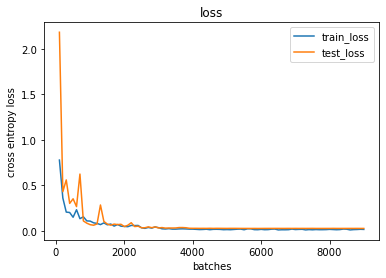

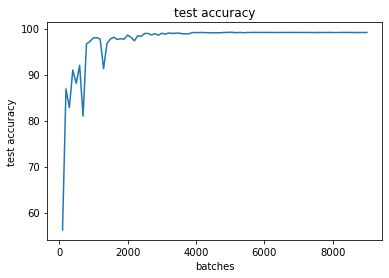

In [7]:
plot_loss(LeNN)
plot_acc(LeNN)

In [21]:
print("Training time:")
print(f"mean: {round(np.mean(LeNN.train_time), 3)}")
print(f"std: {round(np.std(LeNN.train_time), 3)}")

Training time:
mean: 0.703
std: 0.138


In [19]:
inference_times = inference_time(LeNN, test_dataloader, device)
print("Inference time")
print(format(np.mean(inference_times), ".3e"))
print(format(np.std(inference_times), ".1e"))

Inference time
5.578e+05
9.3e+04


## MNIST LeASLNet

In [11]:
# mock train_function of Optimizer to load the optimizer
ASL_train_function = None

with open('models/LeNet/LeASLNet_optimizer.pkl', 'rb') as file:
    LeASLNet_optim = pickle.load(file)

best_parameters = LeASLNet_optim.get_best_parameters(3)
print(best_parameters)
parameters = best_parameters[0]

[{'acc': 99.64666666666666, 'lr': 0.4318430270465593, 'momentum': 0.5504980468750001, 'p_randomTransform': 0.00041015625000001554}, {'acc': 99.52166666666666, 'lr': 0.47607421875, 'momentum': 0.51025390625, 'p_randomTransform': 0.0224609375}, {'acc': 99.27666666666667, 'lr': 0.031142578125000014, 'momentum': 0.9078222656249999, 'p_randomTransform': 0.5410533338955021}]


In [12]:
from Models import LeASLNet

LeASLNN = LeASLNet(input_shape, num_labels, initial_lr=parameters["lr"], momentum=parameters["momentum"], weight_decay=0, device=device, expansion_rate=1)

summary(LeASLNN, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
LeASLNet                                 [100, 10]                 --
├─Sequential: 1-1                        --                        --
│    └─Conv2d: 2-1                       [100, 6, 28, 28]          156
│    └─BatchNorm2d: 2-2                  [100, 6, 28, 28]          12
│    └─Tanh: 2-3                         [100, 6, 28, 28]          --
│    └─AvgPool2d: 2-4                    [100, 6, 14, 14]          --
│    └─CSC_block: 2-5                    [100, 16, 14, 14]         --
│    │    └─Sequential: 3-1              --                        108
│    │    └─Conv2d: 3-2                  [100, 16, 14, 14]         112
│    └─Tanh: 2-6                         [100, 16, 14, 14]         --
│    └─AvgPool2d: 2-7                    [100, 16, 7, 7]           --
│    └─Flatten: 2-8                      [100, 784]                --
│    └─Linear: 2-9                       [100, 120]                94,200
│    └─T

In [16]:
PATH = "models/LeNet/LeASLNet.pth"

if exists(PATH):
    LeASLNN = torch.load(PATH)
    LeASLNN.eval()

In [17]:
criterion = CrossEntropyLoss()
epochs = 15

train_NN(LeASLNN, criterion, train_dataloader, test_dataloader, epochs=epochs, batches_to_test=100,
        patience=2,device=device, print_test=True, verbose=True, p_randomTransform=parameters["p_randomTransform"])

[1,   100] train_loss: 0.009
test_loss: 0.034, test_accuracy: 98.98
[1,   200] train_loss: 0.012
test_loss: 0.034, test_accuracy: 98.98
[1,   300] train_loss: 0.013
test_loss: 0.034, test_accuracy: 98.98
[1,   400] train_loss: 0.012
test_loss: 0.034, test_accuracy: 98.98
Epoch 00004: reducing learning rate of group 0 to 1.6474e-06.
[1,   500] train_loss: 0.012
test_loss: 0.034, test_accuracy: 98.98
[1,   600] train_loss: 0.012
test_loss: 0.034, test_accuracy: 98.98
[2,   100] train_loss: 0.013
test_loss: 0.034, test_accuracy: 98.97
Epoch 00007: reducing learning rate of group 0 to 8.2368e-07.
[2,   200] train_loss: 0.011
test_loss: 0.034, test_accuracy: 98.98
[2,   300] train_loss: 0.012
test_loss: 0.034, test_accuracy: 98.98
[2,   400] train_loss: 0.011
test_loss: 0.034, test_accuracy: 98.98
Epoch 00010: reducing learning rate of group 0 to 4.1184e-07.
[2,   500] train_loss: 0.012
test_loss: 0.034, test_accuracy: 98.98
[2,   600] train_loss: 0.011
test_loss: 0.034, test_accuracy: 98.9

In [18]:
torch.save(LeASLNN, "./models/LeNet/LeASLNet.pth")

In [13]:
LeASLNN = torch.load("./models/LeNet/LeASLNet.pth")

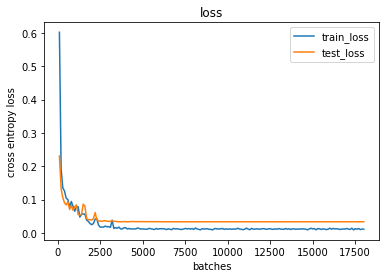

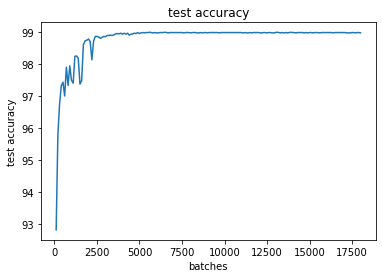

In [14]:
plot_loss(LeASLNN)
plot_acc(LeASLNN)

In [17]:
print("Training time (s):")
print(f"mean: {np.mean(LeASLNN.train_time)}")
print(f"std: {np.std(LeASLNN.train_time)}")

Training time (s):
mean: 0.660877509238889
std: 0.12792679970656584


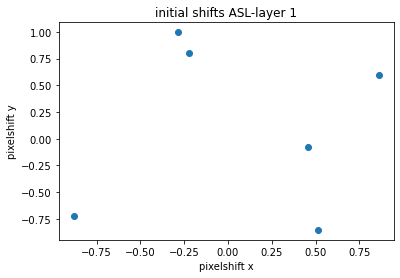

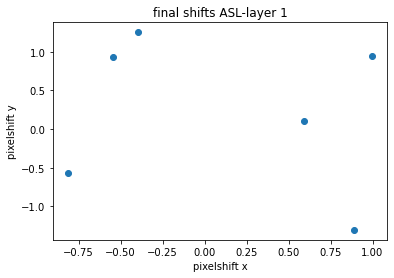

In [16]:
plot_shifts(LeASLNN)

## MNIST LeDepthNet

In [4]:
# mock train_function of Optimizer to load the optimizer
train_function = None

with open('models/LeNet/LeDepthNet_optimizer.pkl', 'rb') as file:
    LeDepthNet_optim = pickle.load(file)

best_parameters = LeDepthNet_optim.get_best_parameters(3)
print(best_parameters)
parameters = best_parameters[0]

[{'acc': 99.40833333333333, 'lr': 0.385712890625, 'momentum': 0.5377679553024513, 'p_randomTransform': 0.017723451102000187}, {'acc': 99.36833333333334, 'lr': 0.3125, 'momentum': 0.5625, 'p_randomTransform': 0.375}, {'acc': 99.35666666666667, 'lr': 0.09375, 'momentum': 0.65625, 'p_randomTransform': 0.3125}]


In [6]:
from Models import LeDepthNet

LeDepthNN = LeDepthNet(input_shape, num_labels, initial_lr=parameters["lr"], momentum=parameters["momentum"], weight_decay=0)

summary(LeDepthNN, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
LeDepthNet                               [100, 10]                 --
├─Sequential: 1-1                        --                        --
│    └─Conv2d: 2-1                       [100, 6, 28, 28]          156
│    └─BatchNorm2d: 2-2                  [100, 6, 28, 28]          12
│    └─Tanh: 2-3                         [100, 6, 28, 28]          --
│    └─AvgPool2d: 2-4                    [100, 6, 14, 14]          --
│    └─Depth_wise_block: 2-5             [100, 16, 14, 14]         --
│    │    └─Sequential: 3-1              --                        226
│    └─Tanh: 2-6                         [100, 16, 14, 14]         --
│    └─AvgPool2d: 2-7                    [100, 16, 7, 7]           --
│    └─Flatten: 2-8                      [100, 784]                --
│    └─Linear: 2-9                       [100, 120]                94,200
│    └─Tanh: 2-10                        [100, 120]                --
│    └─Li

In [7]:
PATH = "models/LeNet/LeDepthNet.pth"

if exists(PATH):
    LeDepthNN = torch.load(PATH)
    LeDepthNN.eval()

In [8]:
criterion = CrossEntropyLoss()
epochs = 15

train_NN(LeDepthNN, criterion, train_dataloader, test_dataloader, epochs=epochs, batches_to_test=100,
        patience=2,device=device, print_test=True, verbose=True, p_randomTransform=parameters["p_randomTransform"])

[1,   100] train_loss: 0.675
test_loss: 0.294, test_accuracy: 90.35
[1,   200] train_loss: 0.232
test_loss: 0.150, test_accuracy: 95.23
[1,   300] train_loss: 0.214
test_loss: 0.149, test_accuracy: 95.28
[1,   400] train_loss: 0.156
test_loss: 0.172, test_accuracy: 94.45
[1,   500] train_loss: 0.196
test_loss: 0.254, test_accuracy: 91.96
[1,   600] train_loss: 0.192
test_loss: 0.184, test_accuracy: 94.35
[2,   100] train_loss: 0.186
test_loss: 0.149, test_accuracy: 95.44
Epoch 00007: reducing learning rate of group 0 to 1.9286e-01.
[2,   200] train_loss: 0.167
test_loss: 0.108, test_accuracy: 96.85
[2,   300] train_loss: 0.107
test_loss: 0.084, test_accuracy: 97.48
[2,   400] train_loss: 0.092
test_loss: 0.109, test_accuracy: 96.67
[2,   500] train_loss: 0.108
test_loss: 0.099, test_accuracy: 96.98
[2,   600] train_loss: 0.078
test_loss: 0.065, test_accuracy: 98.05
[3,   100] train_loss: 0.109
test_loss: 0.070, test_accuracy: 97.95
[3,   200] train_loss: 0.060
test_loss: 0.062, test_ac

In [12]:
torch.save(LeDepthNN, "./models/LeNet/LeDepthNet.pth")

In [13]:
LeDepthNN = torch.load("./models/LeNet/LeDepthNet.pth")

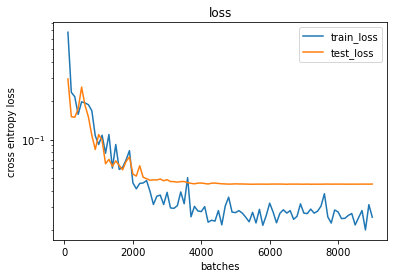

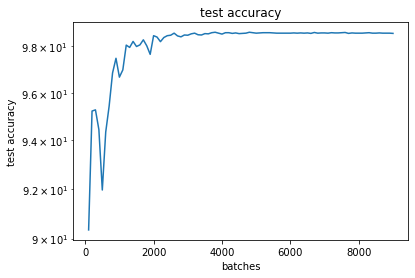

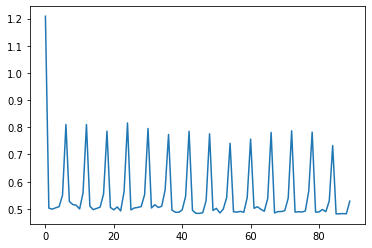

0.5570521119888889
0.12315931945866965


In [17]:
plot_loss(LeDepthNN)
plot_acc(LeDepthNN)

plt.plot(LeDepthNN.train_time)
plt.show()
print(np.mean(LeDepthNN.train_time))
print(np.std(LeDepthNN.train_time))